# Study of whiten by gwpy

Let's first get some data from gwosc

## Some examples

In [23]:
try:
    import numpy
except ImportError:
    !pip install numpy
    import numpy

try:
    import gwpy.timeseries
except ImportError:
    !pip install gwpy
    import gwpy.time

try:
    import gwosc.datasets
except ImportError:
    !pip install gwosc
    import gwosc.datasets

try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt
    

event_name = 'GW150914-v3'
detector_id = "H1"
duration =100

event_gps = gwosc.datasets.event_gps(event_name)
start_time = event_gps - duration / 2
end_time = event_gps + duration / 2 - 1 / 4096
event = gwpy.timeseries.TimeSeries.fetch_open_data(
    detector_id,
    start_time,
    end_time,
    4096,
    verbose=True,
)

Fetched 1 URLs from gwosc.org for [1126259412 .. 1126259513))


Reading data... [Done]


Let's visualize the data

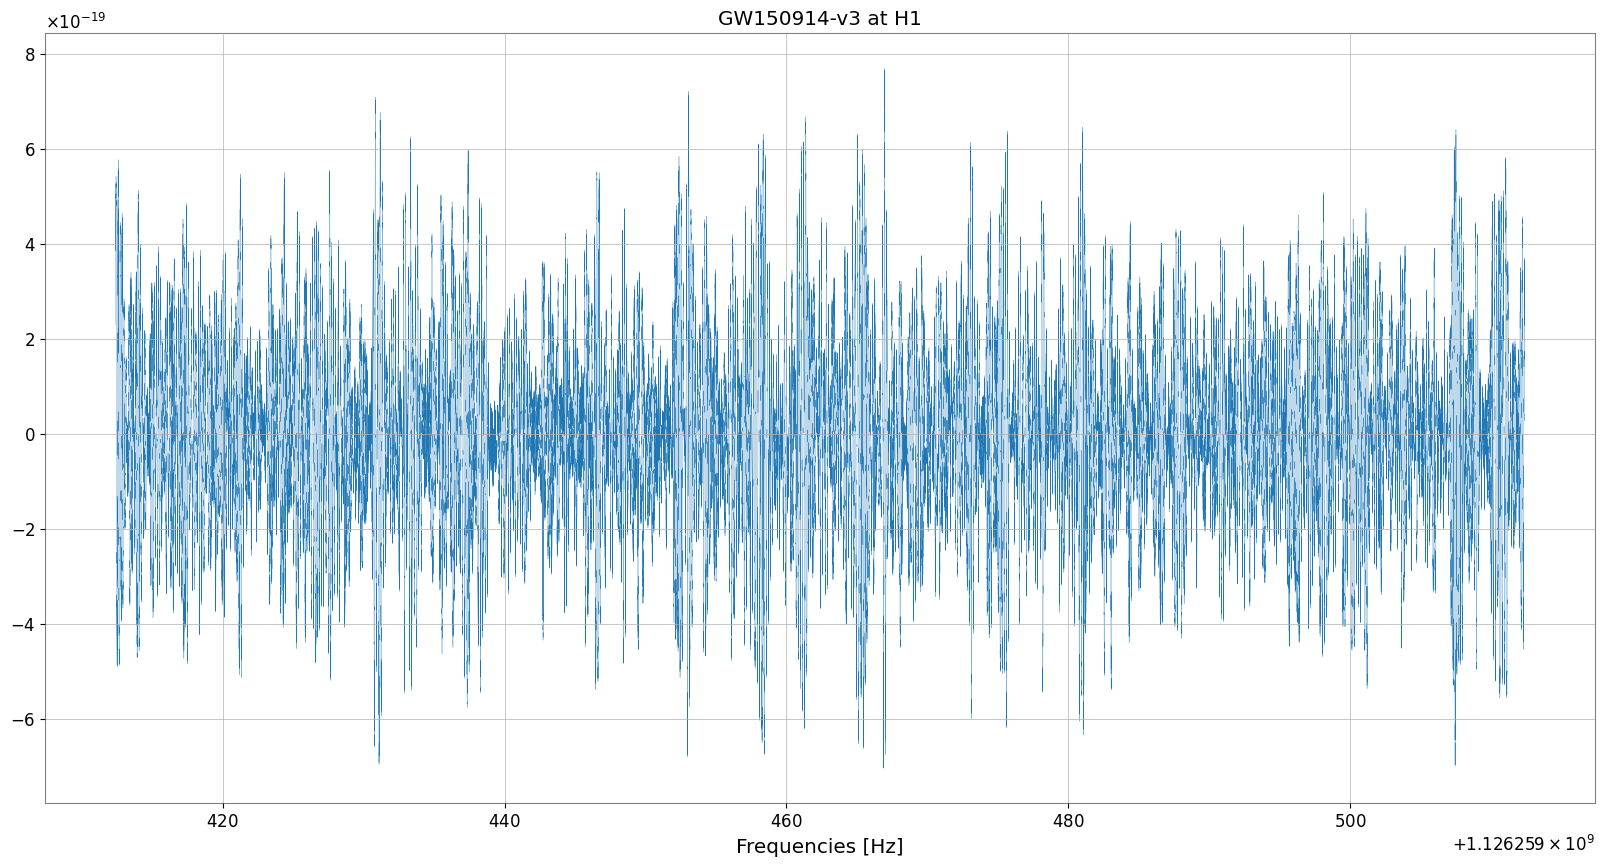

In [24]:
import matplotlib.pyplot as plt
import numpy
plt.figure(figsize=(20, 10))
plt.plot(event.times, event.value, lw="0.2")
plt.xlabel('Frequencies [Hz]')
plt.title(f'{event_name} at {detector_id}')

plt.show()

In `gwpy` the method `whiten()` can be called from the object itself:

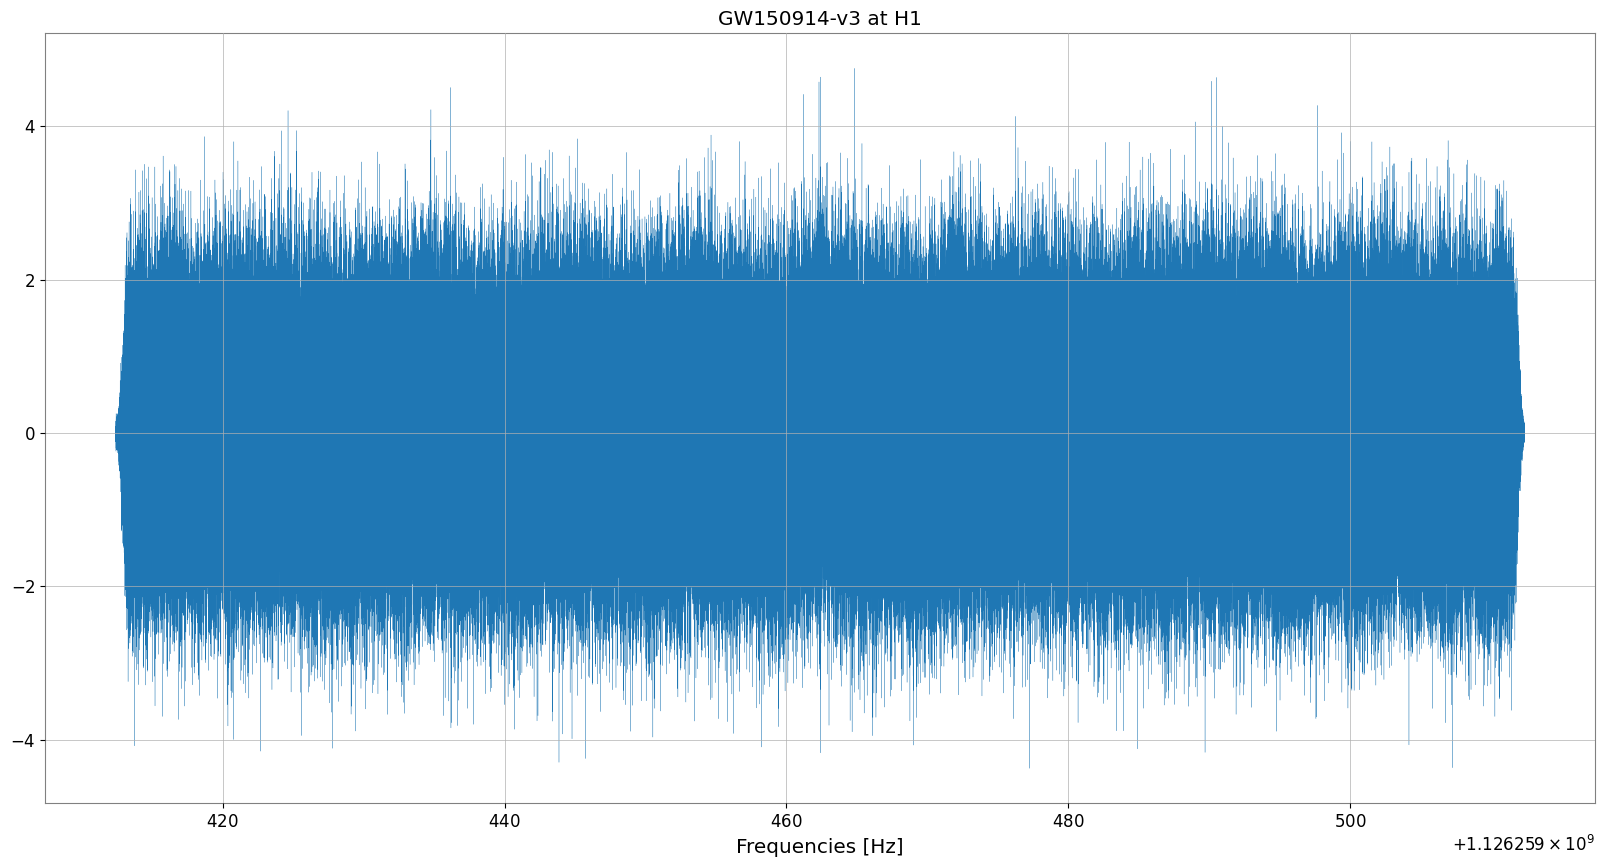

In [25]:
whitened_data = event.whiten()

plt.figure(figsize=(20, 10))
plt.plot(event.times, whitened_data.value, lw=0.2)
plt.xlabel("Frequencies [Hz]")
plt.title(f"{event_name} at {detector_id}")
plt.show()

Let's explore the whiten function

```python
def whiten(self, fftlength=None, overlap=0, method=DEFAULT_FFT_METHOD,
            window='hann', detrend='constant', asd=None,
            fduration=2, highpass=None, **kwargs):
    # compute the ASD
    fftlength = fftlength if fftlength else _fft_length_default(self.dt)
    if asd is None:
        asd = self.asd(fftlength, overlap=overlap,
                        method=method, window=window, **kwargs)
    asd = asd.interpolate(1./self.duration.decompose().value)
    # design whitening filter, with highpass if requested
    ncorner = int(highpass / asd.df.decompose().value) if highpass else 0
    if isinstance(window, (str, tuple)):
        ntaps = int((fduration * self.sample_rate).decompose().value)
    else:
        window = numpy.asarray(window)
        ntaps = len(window)
    tdw = filter_design.fir_from_transfer(1/asd.value, ntaps=ntaps,
                                            window=window, ncorner=ncorner)
    # condition the input data and apply the whitening filter
    in_ = self.copy().detrend(detrend)
    out = in_.convolve(tdw, window=window)
    return out * numpy.sqrt(2 * in_.dt.decompose().value)
```

So the steps are the following:

- Compute the Amplitude Spectral Density (ASD) and interpolate:
    ```python
        self.asd(fftlength, overlap=overlap,
                            method=method, window=window, **kwargs)
        asd = asd.interpolate(1./self.duration.decompose().value)
    ```
- Eventually apply highpass filter:
    ```python
        ncorner = int(highpass / asd.df.decompose().value) if highpass else 0
    ```
- Design Finite Impulse Response (FIR) filter:
    ```python
        tdw = filter_design.fir_from_transfer(1/asd.value, ntaps=ntaps,
                                                window=window, ncorner=ncorner)
    ```
- Apply whitening filter:
    ```python
        in_ = self.copy().detrend(detrend)
        out = in_.convolve(tdw, window=window)
        return out * numpy.sqrt(2 * in_.dt.decompose().value)
    ```


I will go through every step analyzing how `gwpy` handles them.

## Amplitude Spectral Density

The ASD is basically just the square root of the `Power Spectral Density`

$$ asd = \sqrt{psd} $$

The `PSD` is computed using the function `scipy.signal.welch()`. It's pretty nested, however I managed to find how it is done. Basically one can choose between 3 :
```python
        """
        Notes
        -----
        The accepted ``method`` arguments are:

        - ``'bartlett'`` : a mean average of non-overlapping periodograms
        - ``'median'`` : a median average of overlapping periodograms
        - ``'welch'`` : a mean average of overlapping periodograms
        """
```
Those are implemented using the same function from `welch()` from scipy.

```python
def welch(timeseries, segmentlength, **kwargs):
    """Calculate a PSD using Welch's method
    """
    kwargs.setdefault('average', 'mean')
    return _spectral_density(timeseries, segmentlength, **kwargs)


def bartlett(timeseries, segmentlength, **kwargs):
    """Calculate a PSD using Bartlett's method
    """
    kwargs.pop('noverlap', None)
    return _spectral_density(timeseries, segmentlength, noverlap=0, **kwargs)


def median(timeseries, segmentlength, **kwargs):
    """Calculate a PSD using Welch's method with a median average
    """
    kwargs.setdefault('average', 'median')
    return _spectral_density(timeseries, segmentlength, **kwargs)
```

where `_spectral_density()` is:
```python
def _spectral_density(timeseries, segmentlength, noverlap=None, name=None,
                      sdfunc=scipy.signal.welch, **kwargs):
    """Calculate a generic spectral density of this `TimeSeries`
    """
    # compute spectral density
    freqs, psd_ = sdfunc(
        timeseries.value,
        noverlap=noverlap,
        fs=timeseries.sample_rate.decompose().value,
        nperseg=segmentlength,
        **kwargs
    )
    ...
```

Summarizing it should be pretty straightforward to implement this.

### Implementing the ASD computation

let's first implement the function welch with all due parameters:

In [26]:
import matplotlib.pyplot as plt

import scipy.signal
from numpy.typing import NDArray

# define a winodw for the welch operation
window = scipy.signal.get_window("hamming", 256)

# visualize
# plt.plot(window)
# plt.show()


def welch(
    strain: NDArray,
    sampling_rate: int,
    window: NDArray = window,  # by giving explicitly the window is easier to visualize what's happening
    segments_overlap: (
        int | None
    ) = None,  # If None, the default value is used, that is window_len / 2
):
    return scipy.signal.welch(
        strain, sampling_rate, window, noverlap=segments_overlap, average="mean"
    )


def bartlett(
    strain: NDArray,
    sampling_rate: int,
    window: NDArray = window,  # by giving explicitly the window is easier to visualize what's happening
    segments_overlap: (
        int | None
    ) = None,  # If None, the default value is used, that is window_len / 2
):
    return scipy.signal.welch(strain, sampling_rate, window, noverlap=0)


def median(
    strain: NDArray,
    sampling_rate: int,
    window: NDArray = window,  # by giving explicitly the window is easier to visualize what's happening
    segments_overlap: (
        int | None
    ) = None,  # If None, the default value is used, that is window_len / 2
):
    return scipy.signal.welch(
        strain, sampling_rate, window, noverlap=segments_overlap, average="median"
    )


psd_methods = {
    "welch": welch,
    "bartlett": bartlett,
    "median": median,
}


def power_spectral_density(
    strain: NDArray,
    sampling_rate: int,
    window: NDArray = window,  # by giving explicitly the window is easier to visualize what's happening
    noverlap: (
        int | None
    ) = None,  # If None, the default value is used, that is window_len / 2
    method: callable = median,
):
    return method(strain, sampling_rate, window, noverlap)


def amplitude_spectral_density(
    strain: NDArray,
    sampling_rate: int,
    window: NDArray = window,  # by giving explicitly the window is easier to visualize what's happening
    noverlap: (
        int | None
    ) = None,  # If None, the default value is used, that is window_len / 2
    method: callable = median,
):
    freqs, asd_ = power_spectral_density(
            strain,
            sampling_rate,
            window,
            noverlap,
            median,
        )
    
    return freqs, numpy.sqrt(asd_)
    

Let's visualize the result

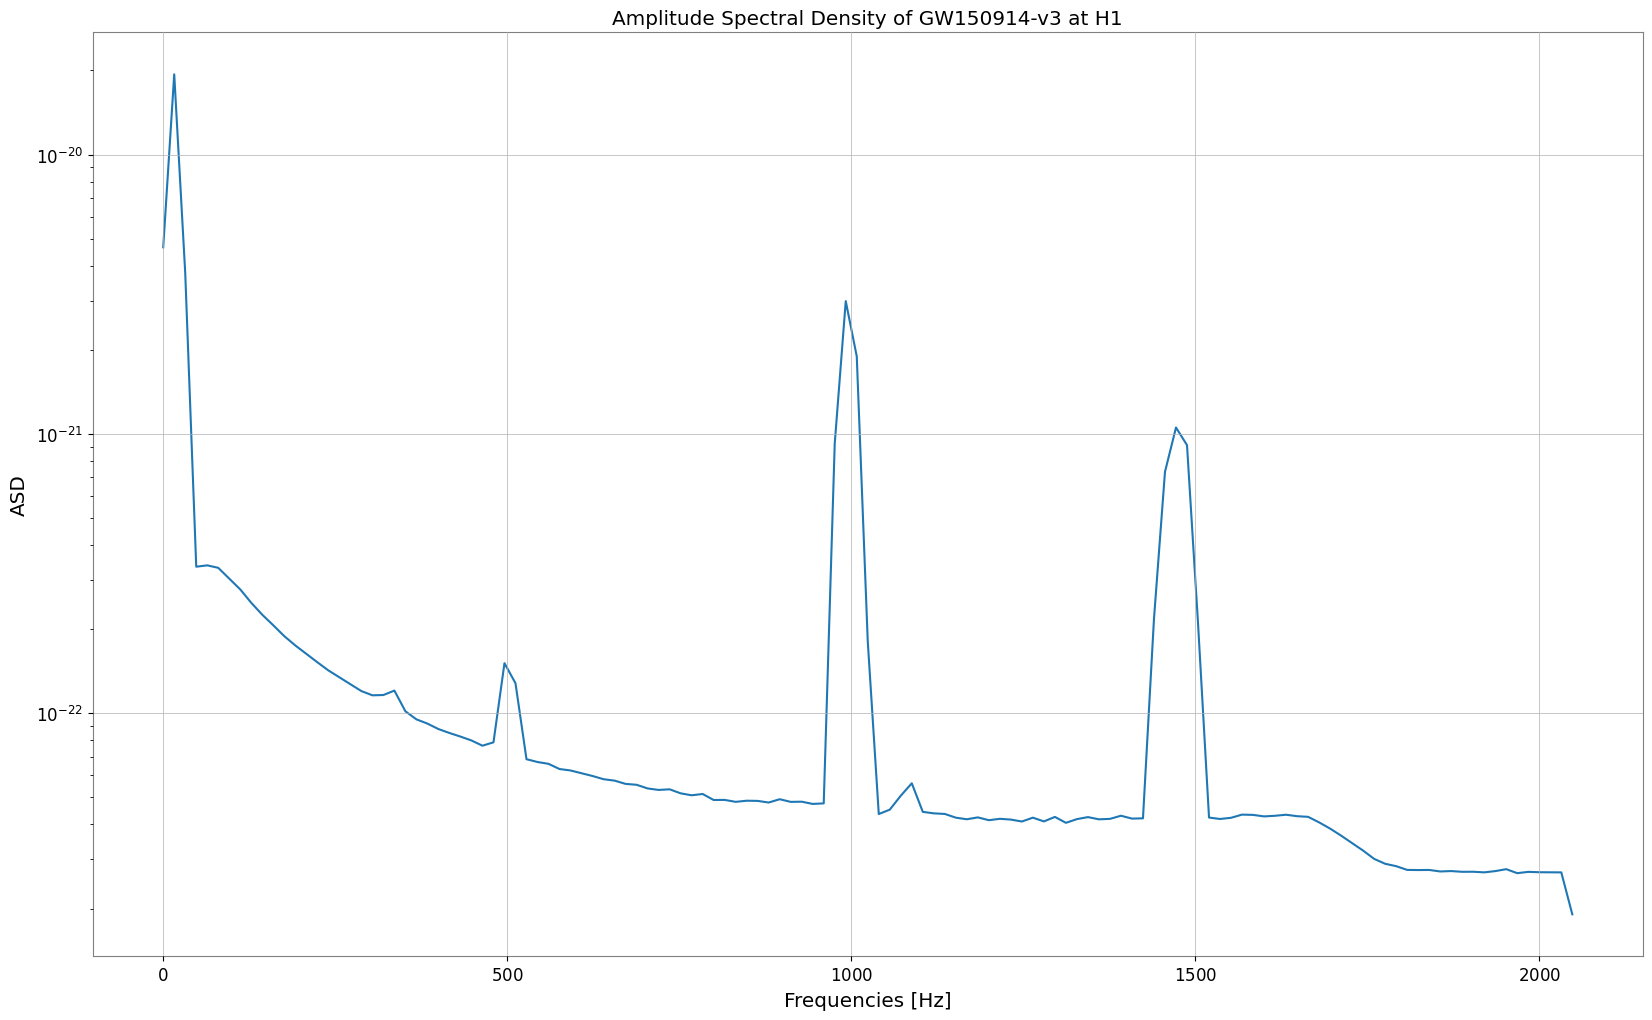

In [27]:
# Get a visual representation of the Power spectral density
freqs, psd_ = amplitude_spectral_density(event.value, event.sample_rate.value)
plt.figure(figsize=(20, 12))
plt.semilogy(freqs, psd_)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('ASD')
plt.title(f"Amplitude Spectral Density of {event_name} at {detector_id}")
plt.show()

### Resampling

As shown, `gwpy` also implements a resampling, using the new sampling rate $$ d_f = \frac{1}{duration} $$. However I'm not very comfortable with the implementation:

```python
    
    def interpolate(self, df):
        f0 = self.f0.decompose().value
        N = (self.size - 1) * (self.df.decompose().value / df) + 1
        fsamples = numpy.arange(0, numpy.rint(N),
                                dtype=self.real.dtype) * df + f0
        out = type(self)(numpy.interp(fsamples, self.frequencies.value,
                                      self.value))
        out.__array_finalize__(self)
        out.f0 = f0
        out.df = df
        return out
```
This is also the [suggested](https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html#tutorial-interpolate-1dsection) usage of `interp` by `scipy` and `numpy`.

So I will mimic the implementation

In [28]:
from numpy.typing import NDArray

def interpolate(fft_data: NDArray, fft_frequencies: NDArray, new_df): 
    new_freqs = numpy.arange(fft_frequencies[0], fft_frequencies[-1], new_df)
    new_fft_data = numpy.interp(new_freqs, fft_frequencies, fft_data)
    return (new_freqs, new_fft_data)

interp_freqs, interp_fft = interpolate(psd_, freqs, 1/event.duration.value)

# To compare let's create gwpy version

from gwpy.frequencyseries import FrequencySeries

fs = FrequencySeries(psd_, frequencies = freqs).interpolate(1 / event.duration.value)

# Shape check
assert fs.shape == interp_fft.shape

# value check
assert all(fs.value - interp_fft == 0)


So as of right now we were able to fully reproduce the behaviour of `gwpy`. Now let's get to the filter.

## FIR Filter

First of all we need to create the filter. In `gwpy` this is done by `fir_from_transfer()`:
```python

    def fir_from_transfer(transfer, ntaps, window='hann', ncorner=None):
        # truncate and highpass the transfer function
        transfer = truncate_transfer(transfer, ncorner=ncorner)
        # compute and truncate the impulse response
        impulse = npfft.irfft(transfer)
        impulse = truncate_impulse(impulse, ntaps=ntaps, window=window)
        # wrap around and normalise to construct the filter
        out = numpy.roll(impulse, int(ntaps/2 - 1))[0:ntaps]
        return out
```
Let's break this

### Truncate and smooth the transfer function

First of all it manipulates the transfer function

The window function code is from `gwpy`, I will work on a better implementation.

```python
def planck(N, nleft=0, nright=0):
    """Return a Planck taper window.

    Parameters
    ----------
    N : `int`
        Number of samples in the output window

    nleft : `int`, optional
        Number of samples to taper on the left, should be less than `N/2`

    nright : `int`, optional
        Number of samples to taper on the right, should be less than `N/2`

    Returns
    -------
    w : `ndarray`
        The window, with the maximum value normalized to 1 and at least one
        end tapered smoothly to 0.

    Examples
    --------
    To taper 0.1 seconds on both ends of one second of data sampled at 2048 Hz:

    >>> from gwpy.signal.window import planck
    >>> w = planck(2048, nleft=205, nright=205)

    References
    ----------
    .. [1] McKechan, D.J.A., Robinson, C., and Sathyaprakash, B.S. (April
           2010). "A tapering window for time-domain templates and simulated
           signals in the detection of gravitational waves from coalescing
           compact binaries". Classical and Quantum Gravity 27 (8).
           :doi:`10.1088/0264-9381/27/8/084020`

    .. [2] Wikipedia, "Window function",
           https://en.wikipedia.org/wiki/Window_function#Planck-taper_window
    """
    # construct a Planck taper window
    w = numpy.ones(N)
    if nleft:
        w[0] *= 0
        zleft = numpy.array(
            [nleft * (1.0 / k + 1.0 / (k - nleft)) for k in range(1, nleft)]
        )
        w[1:nleft] *= expit(-zleft)
    if nright:
        w[N - 1] *= 0
        zright = numpy.array(
            [-nright * (1.0 / (k - nright) + 1.0 / k) for k in range(1, nright)]
        )
        w[N - nright : N - 1] *= expit(-zright)
    return w

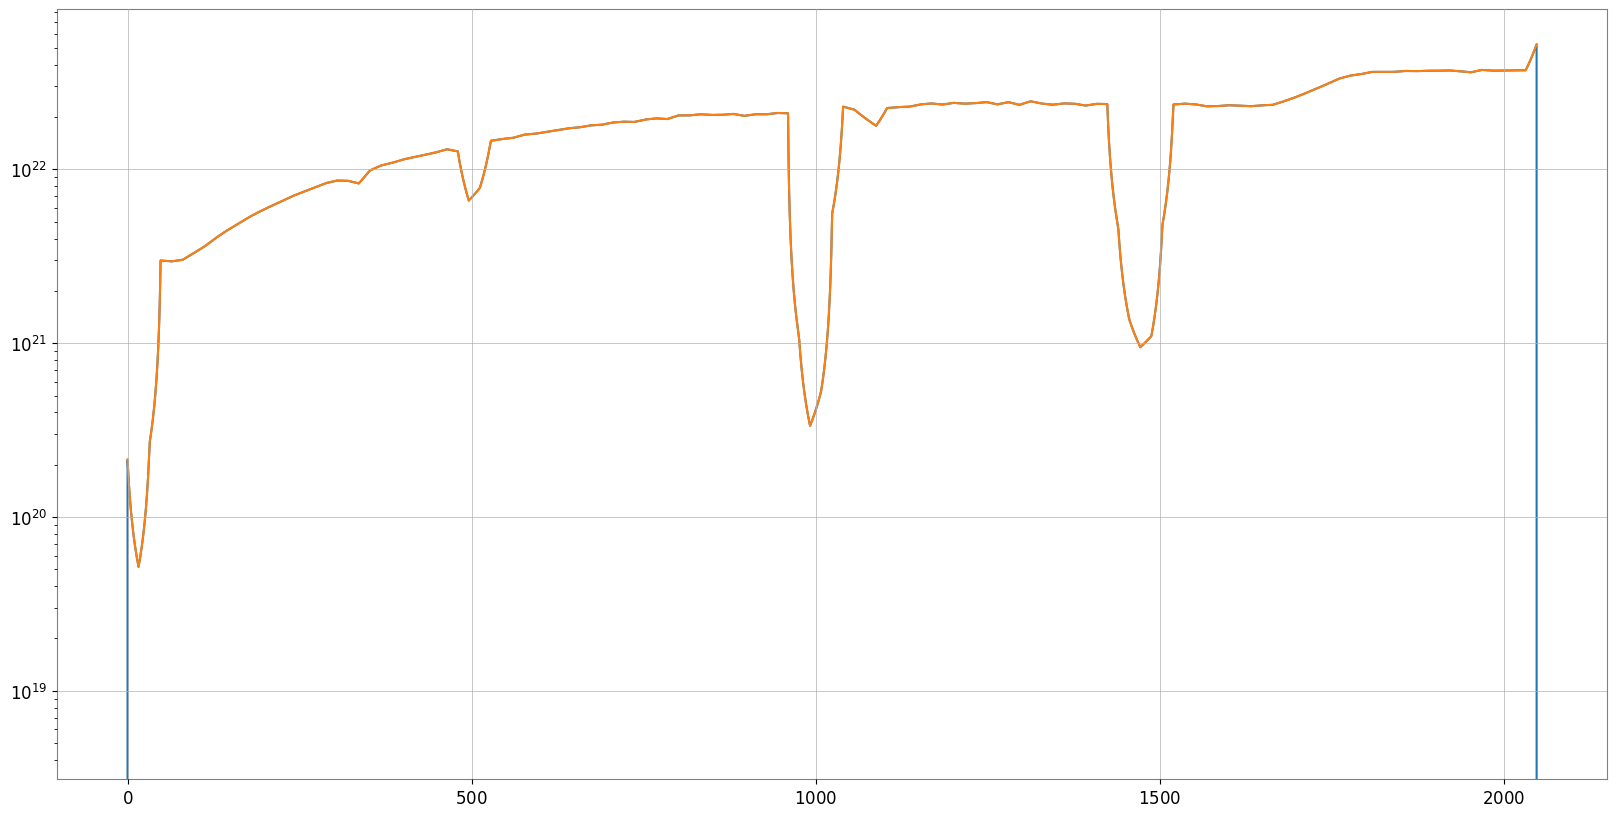

In [29]:
from numpy.typing import NDArray
from gwpy.signal.window import planck


def truncate_n_smooth(arr: NDArray, high_pass_idx: int = 0):
    out = arr.copy()
    out[:high_pass_idx] = 0
    out[high_pass_idx:] *= planck(len(arr) - high_pass_idx, nleft=5, nright=5)
    return out

# visualization
plt.figure(figsize=(20, 10))
plt.semilogy(interp_freqs, truncate_n_smooth(1 / interp_fft))
plt.semilogy(interp_freqs, 1/interp_fft)
plt.show()

### Compute the impulse

Compute the inverse real FFT

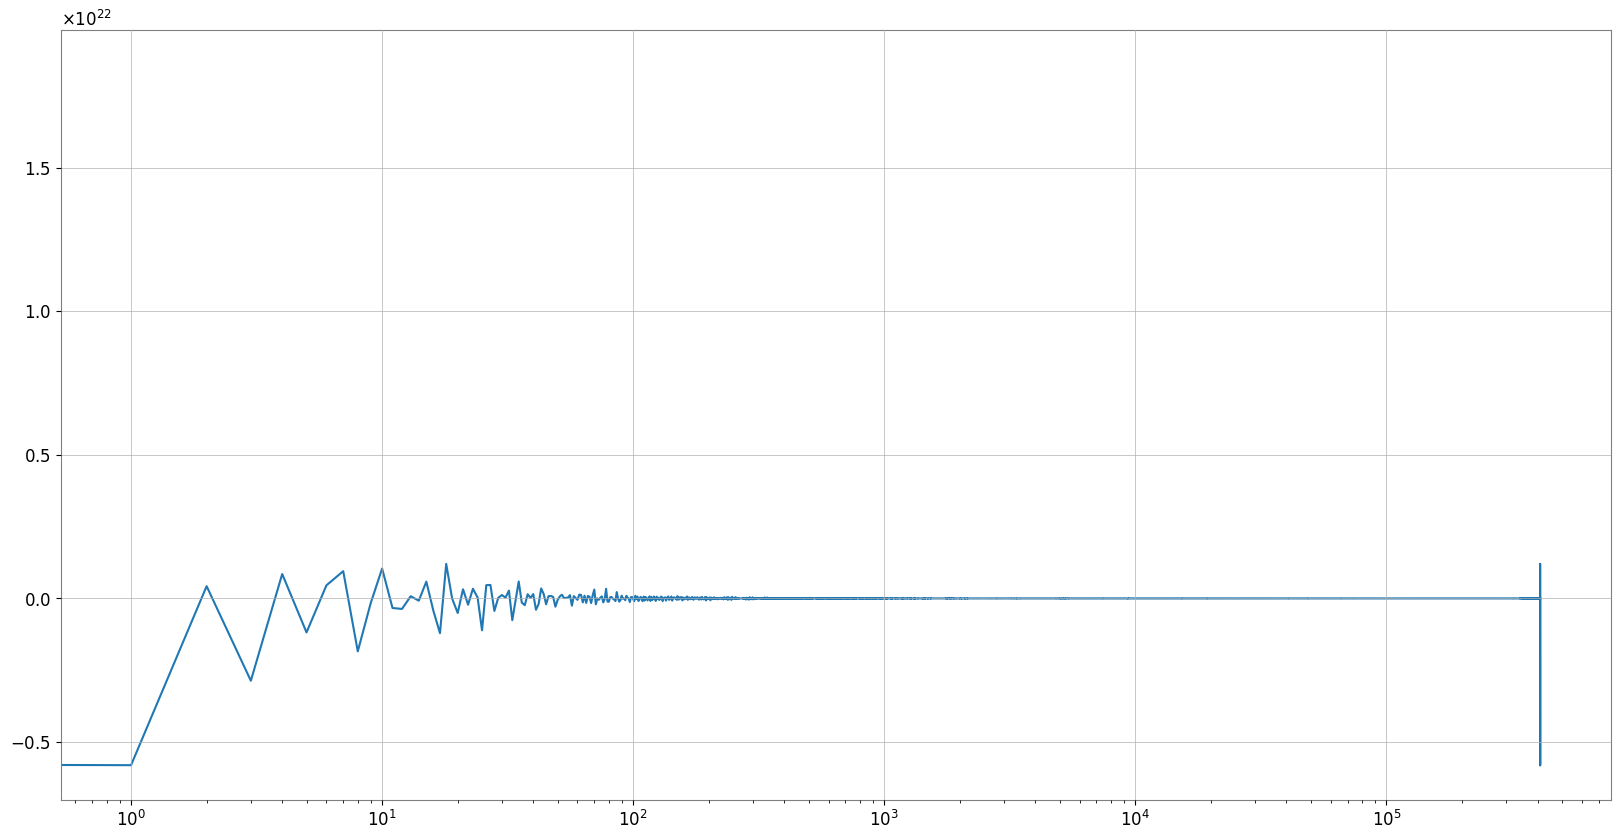

In [30]:
impulse = numpy.fft.irfft(truncate_n_smooth(1 / interp_fft))


# visualization
plt.figure(figsize=(20, 10))
plt.semilogx(impulse)
plt.show()

### Apply window

Straightforward

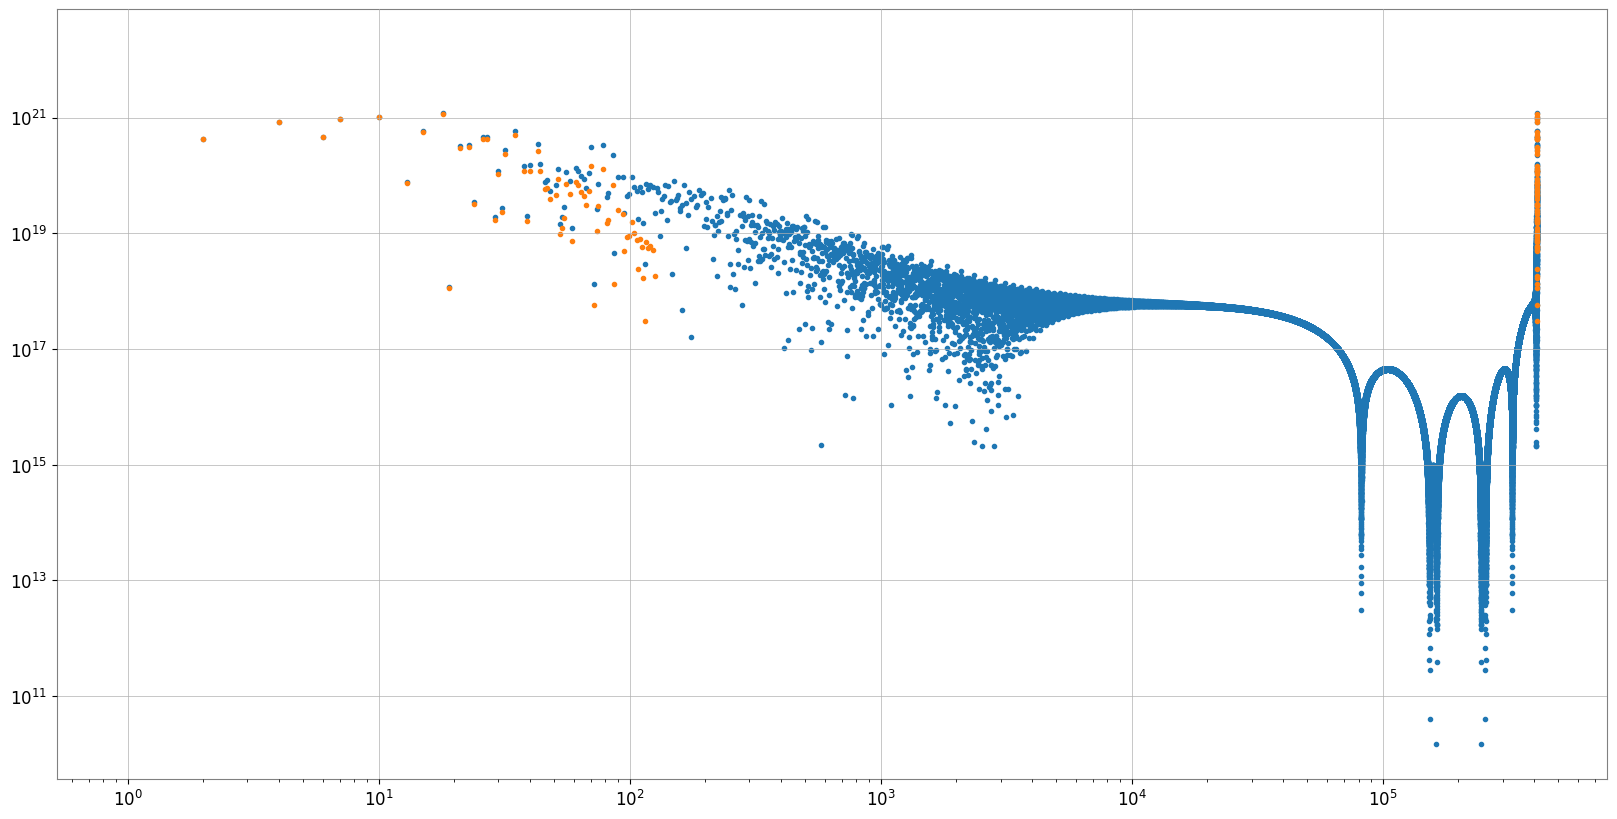

In [31]:
def apply_window(arr: NDArray, window: NDArray):
    out = numpy.zeros_like(arr)
    # Check that window shape is even
    trunc_start = len(window) // 2
    out[0:trunc_start] = arr[0:trunc_start] * window[trunc_start:]
    out[-trunc_start:] =arr[-trunc_start:] *  window[:trunc_start]
    return out


# visualization
plt.figure(figsize=(20, 10))
plt.loglog(impulse, ".")
plt.loglog(apply_window(impulse, window), '.')
plt.show()

### Wrap around and roll normalization (?)

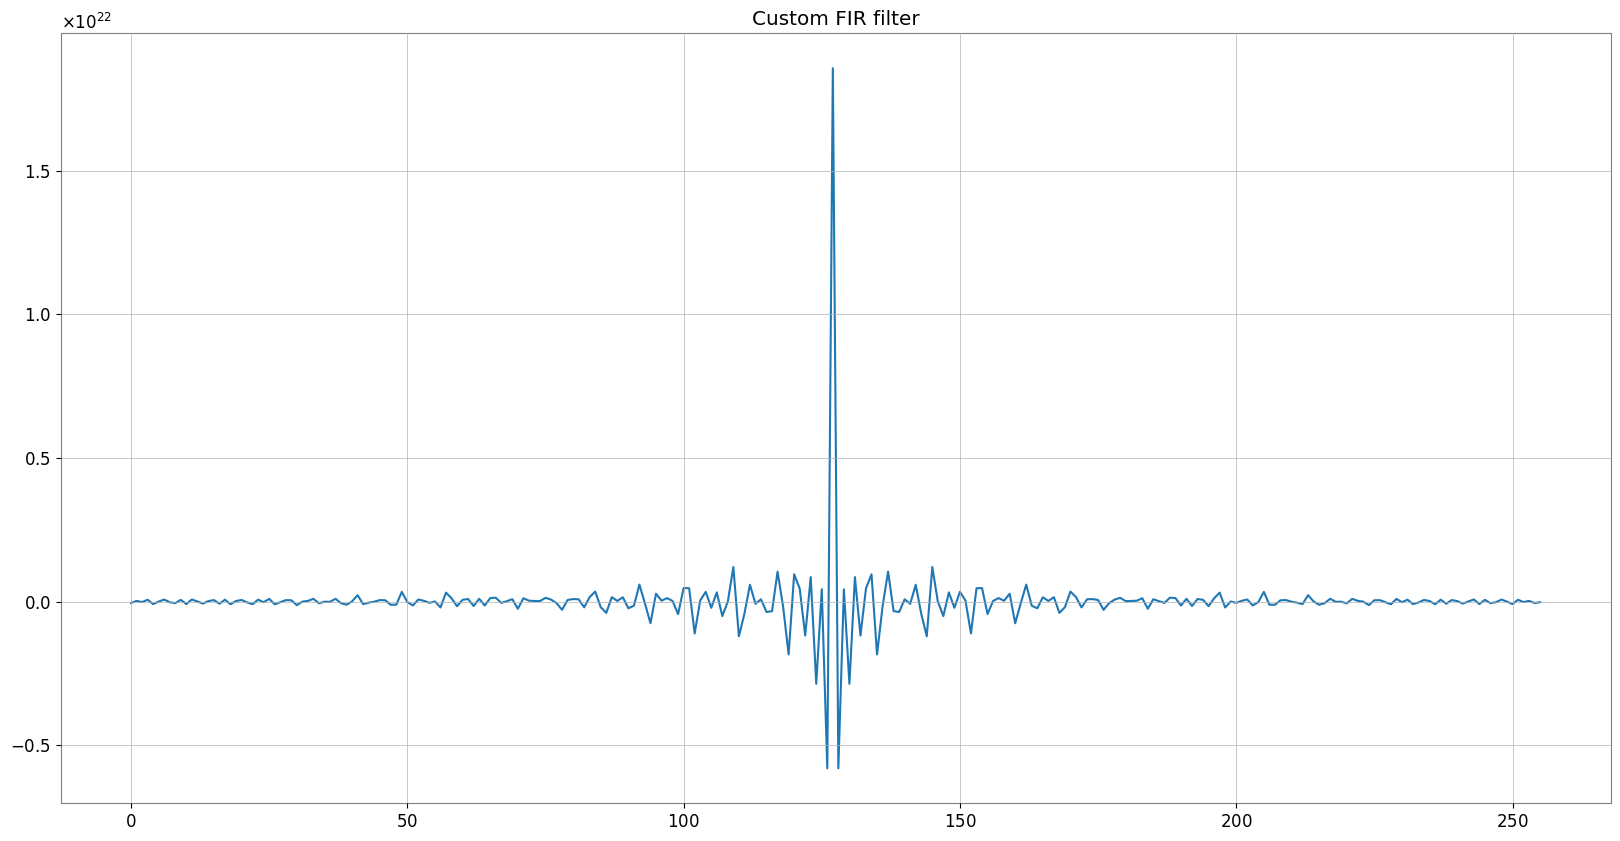

In [32]:
fir = numpy.roll(impulse, int(len(window)/2 - 1))[0:len(window)]

# visualization
plt.figure(figsize=(20, 10))
plt.plot(fir)
plt.title("Custom FIR filter")
plt.show()

## Data condition and whitening

```python
    # condition the input data and apply the whitening filter
    in_ = self.copy().detrend(detrend)
    out = in_.convolve(tdw, window=window)
    return out * numpy.sqrt(2 * in_.dt.decompose().value)


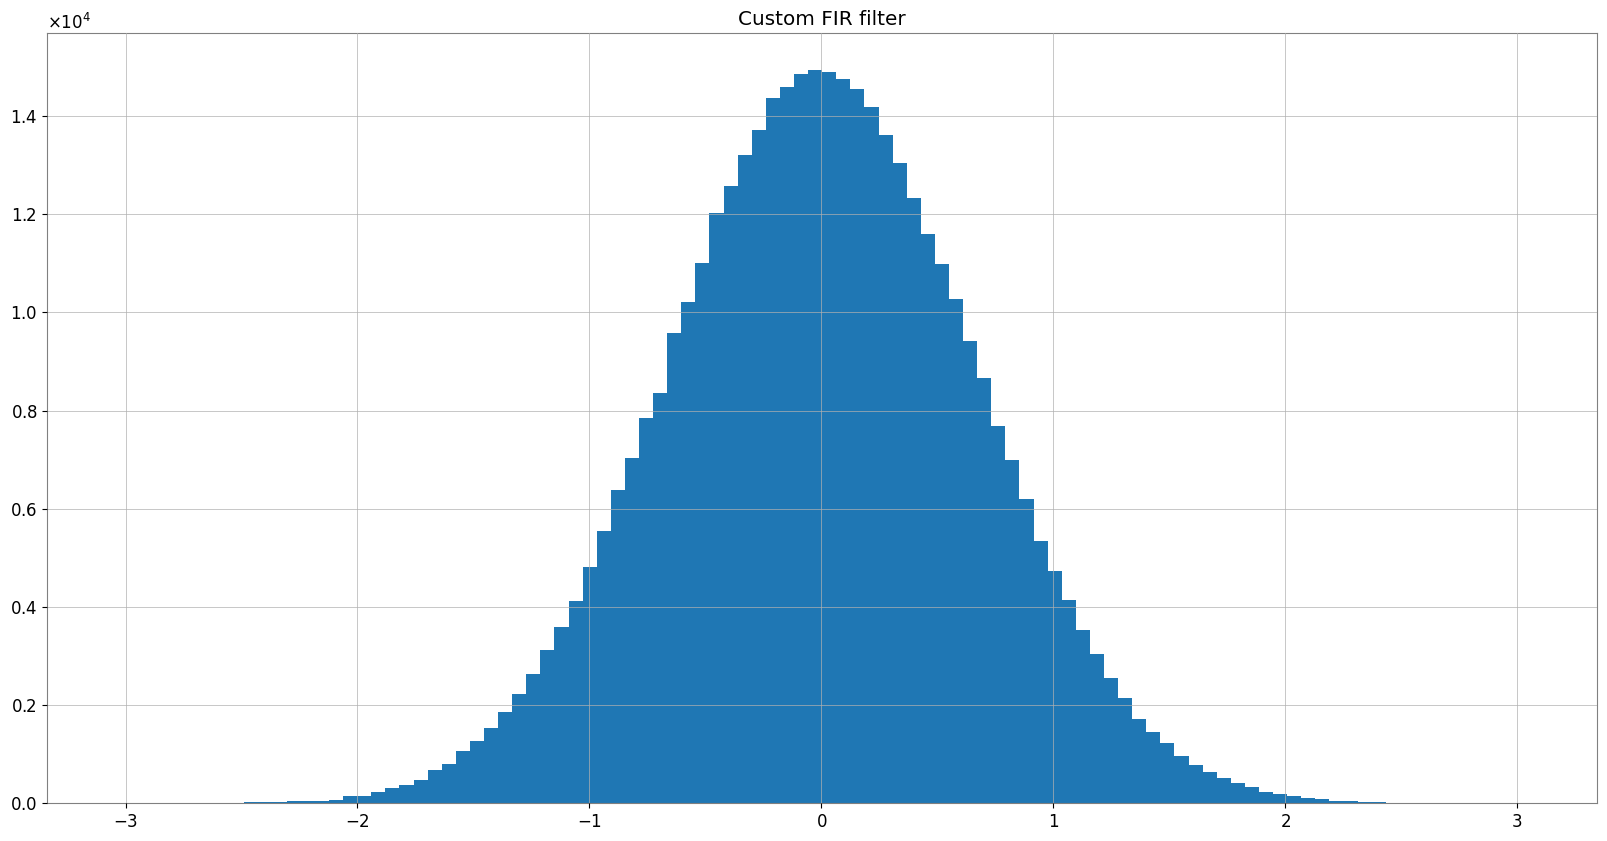

In [35]:
# Detrend
import scipy.signal
detrended_data = scipy.signal.detrend(event.value, type='constant')

# Convolve
# gwpy makes sure that fir.size * 8 >= strain.size
# In my implementation fir.size == window.size
pad = len(window) // 2
detrended_data[:pad] *= window[:pad]
detrended_data[-pad:] *= window[-pad:]
conv = scipy.signal.fftconvolve(detrended_data, fir, mode='same')

# Normalize
white_data = conv * numpy.sqrt(2 * event.dt.value)

# visualization
plt.figure(figsize=(20, 10))
plt.hist(white_data, bins = 100)

plt.title("Custom FIR filter")
plt.show()

## Conclusion

We were able to reproduce `gwpy`'s whiten function!